# SkimLIt
The purpose of this notebook is to build and NLP model to make reading medical abstracts easier.
The paper being replicated for this projecti is available here: https://arxiv.org/abs/1710.06071

### What I'm going to cover
1. Download the text data from (PubMed 200K RCT)
2. Writing a preprocessing fucntions for our text data
3. Setting up multiple modelling experiments  with different levels of embeddings
4. Building a model to take in different sources of data
5. Replicating the model poweringn https::arxiv.org/abs/1710.06071
6. Finding the most wrong predictions


In [1]:
# Confirm access to a GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Get the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 36.20 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are the pubmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Unzip train.zip
!wget https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py

--2023-12-19 04:19:14--  https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10267 (10K) [text/plain]
Saving to: ‘script_functions.py’

script_functions.py 100%[===================>]  10.03K  --.-KB/s    in 0s      

2023-12-19 04:19:15 (86.0 MB/s) - ‘script_functions.py’ saved [10267/10267]



In [5]:
from script_functions import unzip_data
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

In [6]:
# Start experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
# Check all the filenames in the target directory
import os
filenames =[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Create Preprocessing functions

In [8]:
# Visualizing Examples
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list.

    Args:
    filename: a string containing the target filepath.

    Returns:
    A list of strings with one string per line from the target filename.
    """
    with open(filename, "r") as f:
        return f.readlines()


In [9]:
# Read the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:27]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

How the data looks
```[{'line_number':0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity. \n'
   'total_lines': 11},
    ...]
```

## Data Preprocessing

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abrstract line data

  Takes in filename, readis it contents and sorts through each line,
  extracting things linke the target lablel, the text of the sentence,
  how many sentences ar ein the current abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # Get all lines from filename
  abstract_lines= "" # create an empty abstract
  abstract_samples = [] # Create an empt list of abstracts

  # Loop through each line  in the target line
  for line in input_lines:
    if line.startswith("###"): # Chech to see if the string is and ID line
      abstract_id = line
      abstract_lines ="" # reset the asbstract if the line is an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # Split the abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create empty dictionay for each line
        target_text_split = abstract_line.split("\t") # Split the label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfilled, the line contains a labelled outcome
      abstract_lines += line

  return abstract_samples


In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)


CPU times: user 444 ms, sys: 125 ms, total: 569 ms
Wall time: 574 ms


(180040, 30212, 30135)

In [13]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Visualize using a DataFrame

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distributions of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

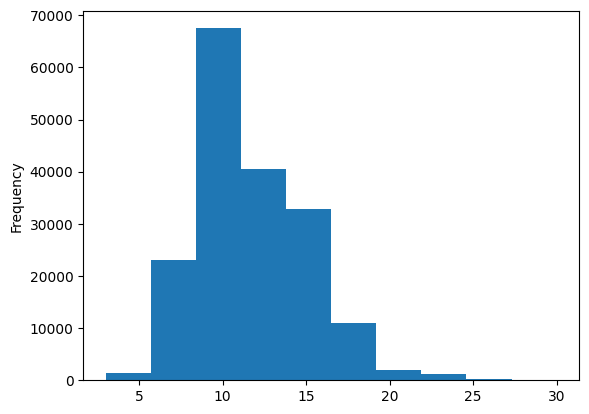

In [16]:
# Check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [17]:
# Converte the abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View the 10 lines of training sentencess
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric models)

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# Check what one hot encoder lables look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:

len(train_labels_one_hot), len(val_labels_one_hot), len(test_labels_one_hot)

(180040, 30212, 30135)

### Label Encode labels

In [21]:
# Extract labels ('target' columms) and encode them into integeres
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels loook like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
len(train_labels_encoded), len(val_labels_encoded), len(test_label_encoded)

(180040, 30212, 30135)

In [23]:
# Get class names and number of classes from LabelEcncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# **Modelling**

## Baseline Model = TF-IDF Multinomial Naive Bayes classifier

In [24]:
# Model_0 the baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
     ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=val_sentences,
            y=val_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate the score
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7397060770554746

In [26]:
len(val_sentences)

30212

In [27]:
# Make prediction using  baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 1, 3, ..., 4, 4, 0])

In [28]:
from script_functions import calculate_results
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 73.97060770554747,
 'precision': 0.7593397029855078,
 'recall': 0.7397060770554746,
 'f1': 0.7099951173338448}

## Preparing the data for  deep sequence models

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
# How long in each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
sent_lens[10]

32

In [31]:
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

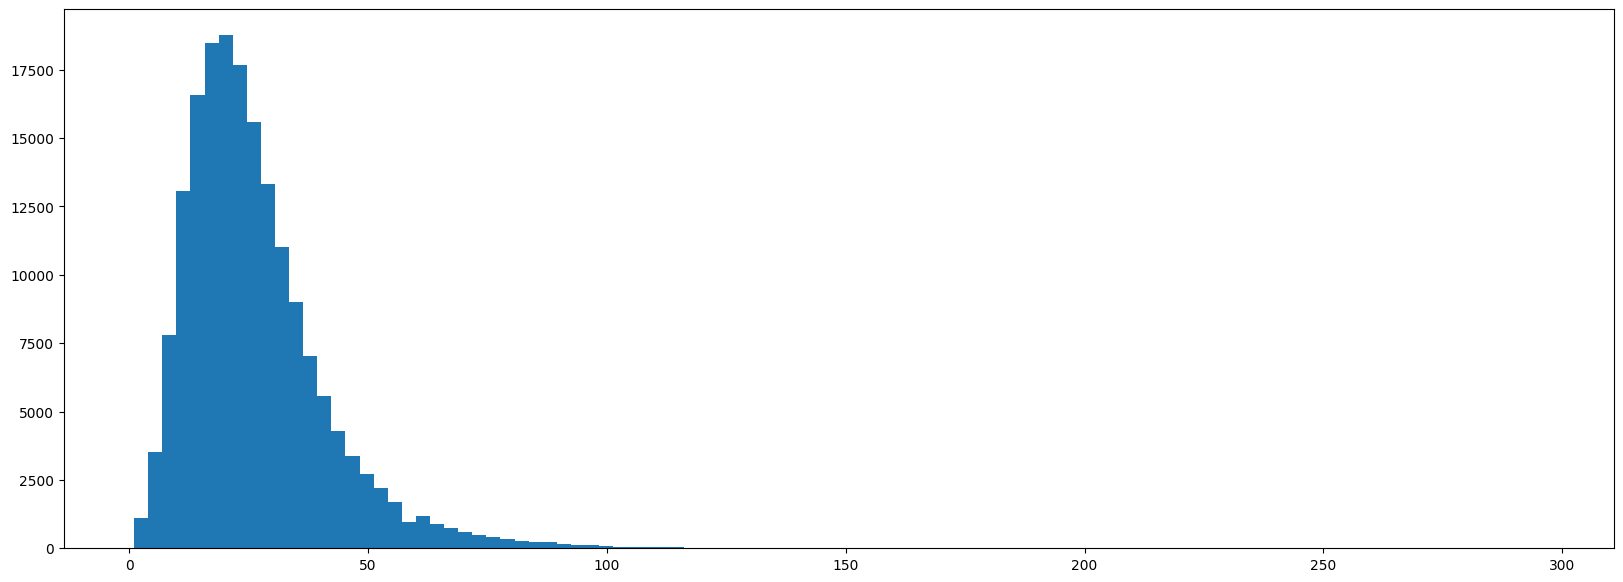

In [32]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7))
plt.hist(sent_lens, bins=100);

In [33]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [34]:
# Maximum sequence length in the training set
max(sent_lens)

296

## Create a text vectorizer Layer

Mapping from text to numbers

In [35]:
# How many words are in our vocabulary (taken from table 2 in ?
max_tokens = 68000

In [36]:
# Create text vectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                       output_sequence_length = 55) # desired output length of vectorized sequences

In [37]:
# Adapt text vectorizer to training sentences
text_vectorization.adapt(train_sentences)

In [38]:
# Test out text vectorizer on random sentences
import random
target_sentences = random.choice(train_sentences)
print(f"Text:\n {target_sentences}")
print(f"\nLength of text: {len(train_sentences)}")
print(f"\nVectorized text: {text_vectorization([target_sentences])}")

Text:
 nine-item patient health questionnaire scores and self-reported need for mental health care did not differ significantly between patients who remained insured and those who lost insurance during the first postpartum year .

Length of text: 180040

Vectorized text: [[29849   127    97   325   119     3   799   483    11   486    97    77
    112    31   544    39    30    12    67   792 13949     3   125    67
   1499  3477    52     2   152  1212   157     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
# How many words in training vocabulary
rct_20k_text_vocab  = text_vectorization.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab : {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab : {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab : ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
# Start the program
text_vectorization.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create Custom text embedding

In [41]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of output vocabulary
                               output_dim = 128, # Note: different embedding sizes result in different parameters to train
                               mask_zero = True, # Use masking to handle variable sequence length
                               name="token_embedding")

In [42]:
# Show example embedding
print(f"Sentence before vectorization: \n {target_sentences} \n")
vectorized_sentence = text_vectorization([target_sentences])
print(f"Sentence after vectorization: \n (before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 nine-item patient health questionnaire scores and self-reported need for mental health care did not differ significantly between patients who remained insured and those who lost insurance during the first postpartum year . 

Sentence after vectorization: 
 (before embedding): 
 [[29849   127    97   325   119     3   799   483    11   486    97    77
    112    31   544    39    30    12    67   792 13949     3   125    67
   1499  3477    52     2   152  1212   157     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding: 
 [[[-0.03765409  0.04639542  0.01090065 ... -0.00744262 -0.01177492
   -0.02763387]
  [ 0.0305643  -0.02340478 -0.00723975 ...  0.00137309  0.03181367
   -0.00794836]
  [ 0.03083381  0.03210953  0.00109408 ... -0.02935244 -0.02842696
   -0.03416221]
  ...
  [ 0.0051569  -0.03949546 -0.02380767 ...  0.03355605 -0.0108

## Createing datasets (making sure the data loads as fast as possible)
Setup  the data to run as fast as possible with the tf.data API

In [43]:
import tensorflow as tf
import time

In [44]:
# Turn data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
len(train_dataset)

180040

In [46]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [47]:
# Take the tensorslicess dataset and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [48]:
len(train_dataset)

5627

## Building a conv1d Model with token embeddings

In [49]:
# Create 1D Conv model to process sequences
inputs  = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorization(inputs)
token_embeddings = token_embed(text_vectors)
x  = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x  = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [50]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [51]:
# Fit the model
history_model_1  = model_1.fit(train_dataset,
                               steps_per_epoch = int(0.1 * len(train_dataset)),
                               epochs=3,
                               validation_data = valid_dataset,
                               validation_steps = int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 70s 122ms/step - loss: 0.9135 - accuracy: 0.6410 - val_loss: 0.6835 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 66s 118ms/step - loss: 0.6598 - accuracy: 0.7537 - val_loss: 0.6333 - val_accuracy: 0.7636
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.6240 - accuracy: 0.7711 - val_loss: 0.6005 - val_accuracy: 0.7839


In [52]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.6045 - accuracy: 0.7831


[0.6045150756835938, 0.7830663323402405]

In [53]:
# Predicion probabilities for each class
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 5s 5ms/step


(array([[3.9401835e-01, 1.9178022e-01, 1.2101796e-01, 2.6897240e-01,
         2.4211025e-02],
        [5.1932538e-01, 2.0276597e-01, 1.4340919e-02, 2.5840706e-01,
         5.1606954e-03],
        [1.4645179e-01, 7.0854239e-03, 2.7731957e-03, 8.4364140e-01,
         4.8236758e-05],
        ...,
        [1.6004929e-06, 7.4787735e-04, 1.0031092e-03, 3.8500893e-06,
         9.9824357e-01],
        [5.9078902e-02, 4.4607633e-01, 1.3727711e-01, 7.9257131e-02,
         2.7831057e-01],
        [1.9322628e-01, 6.7640108e-01, 2.7326258e-02, 3.1883381e-02,
         7.1163088e-02]], dtype=float32),
 (30212, 5))

In [54]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [55]:
# Confirm with classnames
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [56]:
# Caclulate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.30663312591022,
 'precision': 0.77922046502661,
 'recall': 0.7830663312591023,
 'f1': 0.7803402876892961}

In [57]:
baseline_results

{'accuracy': 73.97060770554747,
 'precision': 0.7593397029855078,
 'recall': 0.7397060770554746,
 'f1': 0.7099951173338448}

## Model 2: Feature extraction with pretrained feature embedding

In [58]:
# Download pretrained model
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable= False,
                                        name="universal_sentence_encoder")

In [59]:
# Test out the pretrained embedding on a random sentece
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n {use_embedded_sentence[0][:20]}")
print(f"Length of sentence embeddding: {len(use_embedded_sentence)}")

Random sentence: 
 the data suggest that consumption of jobelyn contributed to improved hemoglobin levels and increased cd@ + t-cell counts in nigerian hiv + patients .
Sentence after embedding: 
 [-0.02662063 -0.01473577  0.02430393 -0.06277916 -0.05110608  0.01968418
  0.00342441 -0.03996868  0.04156296 -0.00945443  0.08459146  0.04865847
  0.0194561   0.04581492  0.00583088 -0.01315281 -0.08450671 -0.05432552
  0.02678798 -0.00253604]
Length of sentence embeddding: 1


### Building and  fitting and NLP feature exteraction model using pretrained embeddings TensorFlow Hub

In [60]:
# Define featuere extraction using  model using TF hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create emebdding of each sequence
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Add more leyers later
outputs = layers.Dense(num_classes, activation='softmax')(x) # Create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [61]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [62]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)),
                              )

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9183 - accuracy: 0.6495 - val_loss: 0.7957 - val_accuracy: 0.6941
Epoch 2/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7683 - accuracy: 0.7012 - val_loss: 0.7525 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7522 - accuracy: 0.7113 - val_loss: 0.7359 - val_accuracy: 0.7184


In [63]:
# Evaluate the dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7405 - accuracy: 0.7153


[0.7405101656913757, 0.7153118252754211]

In [64]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 12ms/step


array([[4.53453451e-01, 3.39314342e-01, 1.78758346e-03, 1.97574630e-01,
        7.87001941e-03],
       [3.67408723e-01, 4.94286478e-01, 2.98485858e-03, 1.32708326e-01,
        2.61164363e-03],
       [2.12144569e-01, 1.20345816e-01, 1.47464275e-02, 6.19736254e-01,
        3.30268368e-02],
       ...,
       [1.69945380e-03, 5.98254520e-03, 5.45523763e-02, 8.54493352e-04,
        9.36911166e-01],
       [4.46888851e-03, 4.76494953e-02, 2.21047103e-01, 1.64704246e-03,
        7.25187540e-01],
       [1.72456712e-01, 2.52734274e-01, 4.95319128e-01, 8.21298826e-03,
        7.12768734e-02]], dtype=float32)

In [65]:
# Convert the prediction probalities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [66]:
# Calculate results
model_2_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_2_preds)
model_2_results

{'accuracy': 71.53117966370979,
 'precision': 0.7156342811907634,
 'recall': 0.7153117966370979,
 'f1': 0.7124680671755271}

## Character Embeddings

### Create a charactere level tokenizer
This is going to map every character in a sequence to some integer

In [67]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [68]:
# Make function to  split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [69]:
split_chars(random_train_sentence)

't h e   d a t a   s u g g e s t   t h a t   c o n s u m p t i o n   o f   j o b e l y n   c o n t r i b u t e d   t o   i m p r o v e d   h e m o g l o b i n   l e v e l s   a n d   i n c r e a s e d   c d @   +   t - c e l l   c o u n t s   i n   n i g e r i a n   h i v   +   p a t i e n t s   .'

In [70]:
# Split sequence level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [71]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

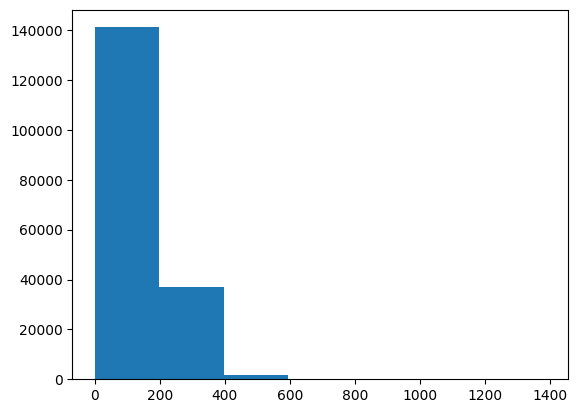

In [72]:
# Check the distribution at Character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [73]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [74]:
# Get all the keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
# Create char level token vectorizer intance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name="char_vectorizer")

In [76]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [77]:
# Check charactere vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in  character vocab : {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in  character vocab : 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [78]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_sentence)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars: \n {vectorized_chars}")
print(f"Lenght of vectorized chars : \n {len(vectorized_chars[0])}")

Charified text: 
 u s i n g   @ - k v p   i m p r o v e d   a r t e r i a l   e n h a n c e m e n t   ,   s n r   ,   a n d   c n r   ,   a n d   p r o v i d e d   b e t t e r   s u b j e c t i v e   i m a g e   q u a l i t y   ,   u s i n g   a   @   %   l o w e r   e f f e c t i v e   d o s e   .
Length of random_train_chars: 149
Vectorized chars: 
 [[16  9  4  6 18 23 21 14  4 15 14  8  7 21  2 10  5  8  3  2  8  4  5 12
   2  6 13  5  6 11  2 15  2  6  3  9  6  8  5  6 10 11  6  8  5  6 10 14
   8  7 21  4 10  2 10 22  2  3  3  2  8  9 16 22 27  2 11  3  4 21  2  4
  15  5 18  2 26 16  5 12  4  3 19 16  9  4  6 18  5 12  7 20  2  8  2 17
  17  2 11  3  4 21  2 10  7  9  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [79]:
# Create character level embedding
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name= "char_embed")

In [80]:
# Test the character embedding layer
print(f"Charified text:n\ {[random_train_chars]}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embed chars. (after vectorization and embedding): \n{char_embed_example})")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:n\ ['u s i n g   @ - k v p   i m p r o v e d   a r t e r i a l   e n h a n c e m e n t   ,   s n r   ,   a n d   c n r   ,   a n d   p r o v i d e d   b e t t e r   s u b j e c t i v e   i m a g e   q u a l i t y   ,   u s i n g   a   @   %   l o w e r   e f f e c t i v e   d o s e   .']
Embed chars. (after vectorization and embedding): 
[[[ 0.01668532  0.00487387  0.02780035 ... -0.01816225  0.02968912
    0.01501036]
  [ 0.00844952  0.01565978  0.01751927 ...  0.03899333 -0.02503595
    0.03076053]
  [ 0.01710682  0.03655836 -0.01305386 ... -0.02761848  0.0330021
   -0.00744991]
  ...
  [ 0.02997608 -0.02976065 -0.02571769 ...  0.00603986 -0.02536316
   -0.04586064]
  [ 0.02997608 -0.02976065 -0.02571769 ...  0.00603986 -0.02536316
   -0.04586064]
  [ 0.02997608 -0.02976065 -0.02571769 ...  0.00603986 -0.02536316
   -0.04586064]]])
Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on charactere embeddings

In [81]:
# Make Conv1D on chars  only
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding = 'same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [82]:
# summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

> Befor fitting the model to the data, optimize the data for faster loading

In [83]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
# Fit the model
model_3_history  = model_3.fit(train_char_dataset,
                               steps_per_epoch = int(0.1 * len(train_char_dataset)),
                               epochs = 3,
                               validation_data = val_char_dataset,
                               validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 20ms/step - loss: 1.2680 - accuracy: 0.4909 - val_loss: 1.0406 - val_accuracy: 0.5967
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.9923 - accuracy: 0.5994 - val_loss: 0.9329 - val_accuracy: 0.6283
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.9170 - accuracy: 0.6379 - val_loss: 0.8681 - val_accuracy: 0.6612


In [85]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[0.1586935 , 0.40439725, 0.03575318, 0.3663664 , 0.03478971],
       [0.14764273, 0.43907517, 0.00995185, 0.38000754, 0.02332265],
       [0.13978603, 0.17851645, 0.13371262, 0.5228614 , 0.02512344],
       ...,
       [0.01637867, 0.03343673, 0.1579633 , 0.02858589, 0.7636354 ],
       [0.03656979, 0.13716747, 0.29853073, 0.17955522, 0.34817672],
       [0.42796844, 0.40905607, 0.04896433, 0.10397539, 0.01003569]],
      dtype=float32)

In [86]:
# Convert prediction probabilities to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [87]:
# Calculate the results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 65.62955117171984,
 'precision': 0.6558765338648003,
 'recall': 0.6562955117171985,
 'f1': 0.6460097964678259}

## Use a Pretained token embedding + character embedding

In [88]:
# Use the funtional api
# 1. Setup token inpus/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model= tf.keras.Model(inputs=token_inputs,
                            outputs = token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs(create hybrid token embeddings)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output_layers -adding in Dropout, discussed the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation= 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name= 'model_4_token_and_char_embeddings')

In [89]:
# Get summary of model_4
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

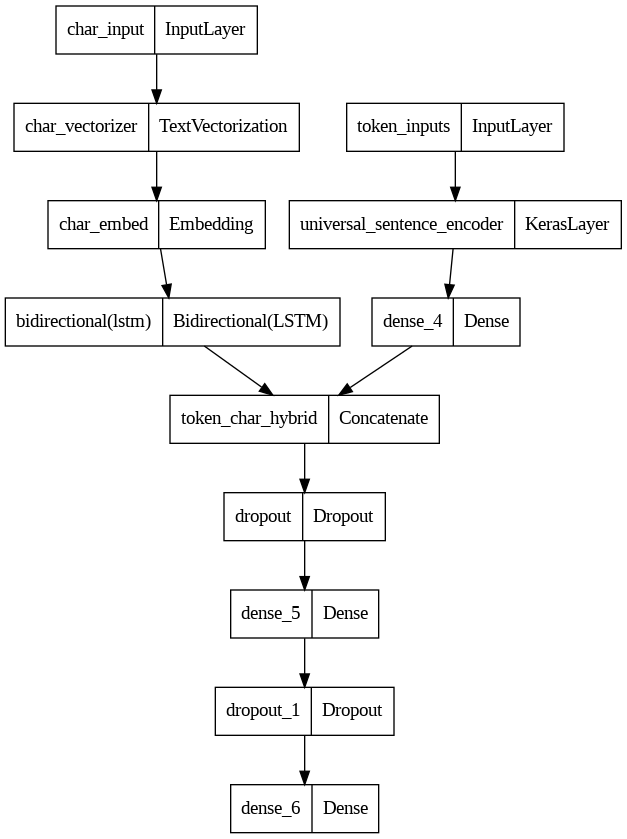

In [90]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4)

In [91]:
# Combine chars and tokesn into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make label
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # Make label
train_char_token_dataset = tf.data.Dataset.zip(train_char_token_data, train_char_token_labels)

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [92]:
# Repeat the above process for the validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip(val_char_token_data, val_char_token_label)

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
# Compile the token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [94]:
# Fit the model
model_4.fit(train_char_token_dataset,
            epochs=3,
            steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
            validation_data = val_char_token_dataset,
            validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 172s 284ms/step - loss: 0.9837 - accuracy: 0.6054 - val_loss: 0.7785 - val_accuracy: 0.6932
Epoch 2/3
562/562 [==============================] - 161s 287ms/step - loss: 0.7981 - accuracy: 0.6953 - val_loss: 0.7124 - val_accuracy: 0.7234
Epoch 3/3
562/562 [==============================] - 156s 278ms/step - loss: 0.7730 - accuracy: 0.7071 - val_loss: 0.6887 - val_accuracy: 0.7427


In [95]:
# Evaluate
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 79s 84ms/step - loss: 0.6961 - accuracy: 0.7351


[0.6960801482200623, 0.735072135925293]

In [96]:
# Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 62s 63ms/step


array([[4.4534424e-01, 3.3441493e-01, 5.8894050e-03, 2.0367934e-01,
        1.0672051e-02],
       [3.9390305e-01, 3.8540602e-01, 2.4960372e-03, 2.1695343e-01,
        1.2415110e-03],
       [3.3341765e-01, 1.1516284e-01, 4.9979731e-02, 4.5983762e-01,
        4.1602116e-02],
       ...,
       [4.7364578e-04, 1.0743787e-02, 8.1245765e-02, 1.8434782e-04,
        9.0735251e-01],
       [6.0281223e-03, 5.8430973e-02, 2.6739520e-01, 2.9404510e-03,
        6.6520524e-01],
       [2.2973913e-01, 4.0574867e-01, 2.7314767e-01, 1.7779317e-02,
        7.3585205e-02]], dtype=float32)

In [97]:
# Convert the pred probs into label
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 2, 2, 4, 1])>

In [98]:
# GEt resulsts of token-char-hybrid model'
model_4_results  = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_4_preds)
model_4_results

{'accuracy': 73.50721567589036,
 'precision': 0.735253908689818,
 'recall': 0.7350721567589037,
 'f1': 0.7332501693053637}

### Pretrained Embeddings + Character embeddings + Positional embeddings

**Nore:**

Any engineered feature used to train a model needs to be available at test time. In this case, `line numbers` and `total lines` are available.

In [99]:
train_samples[:110]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

**Note:** Any engineered features used to train a model need to be available at test time

### Create positional embeddings

In [100]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

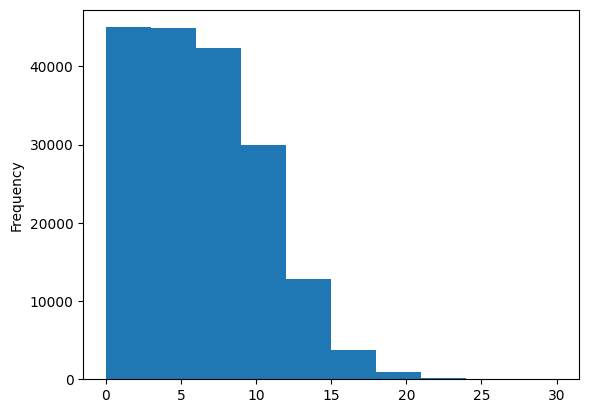

In [101]:
# Check the distriobutions of the line number column
train_df.line_number.plot.hist();

In [102]:
# Use TensorFlow to create one hot encoded
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth =15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [103]:
# How many different number of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

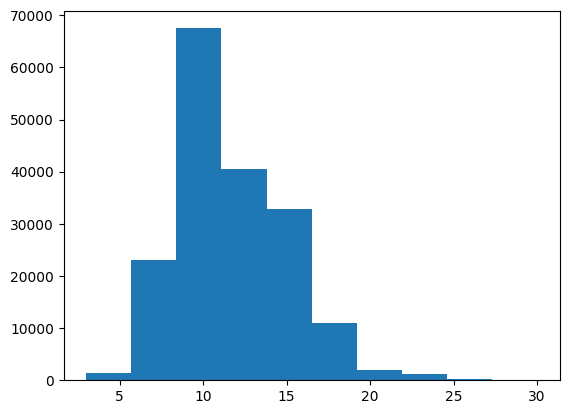

In [104]:
# Plot the distribution
plt.hist(train_df['total_lines']);

In [105]:
# Chek the coverage of  the  percentage of total lines
np.percentile(train_df.total_lines, 98)

20.0

In [106]:
# Uset Tensorflow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

# Building a Tri-Brid Embedding model

1. Create a token level model
2. Create a character level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.concatenate
6. Combine the outputs of 3, 4, and 5 using tf.keras.layers.concatenate
7. Create an ouput layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3, 4 and outputs of 5 into tf.keras.Model

In [108]:
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [115]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line Numbers model
# inputs,shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
# dense layer with 32 units and relu activations
x = layers.Dense(32, activation='relu')(line_number_inputs)
# Combine inputs and dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4 Total lines model
# inputs, shape = ?
total_lines_input = layers.Input(shape=(20), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_input)
total_lines_model = tf.keras.Model(inputs = total_lines_input,
                                   outputs = y)

# 5. Combine token and char embeddings into a hybrd embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_emebdding')([token_model.output,
                                                                              char_model.output])



# Add a  dropout of 0.5 accoording to the original paper
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_poistional_embedding')([line_number_model.output,
                                                                                total_lines_model.output,
                                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name = 'output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer,
                         name='tribrid_embedding_model')


In [116]:
# Get the summary
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_

## Plot model 5 to  visualize it

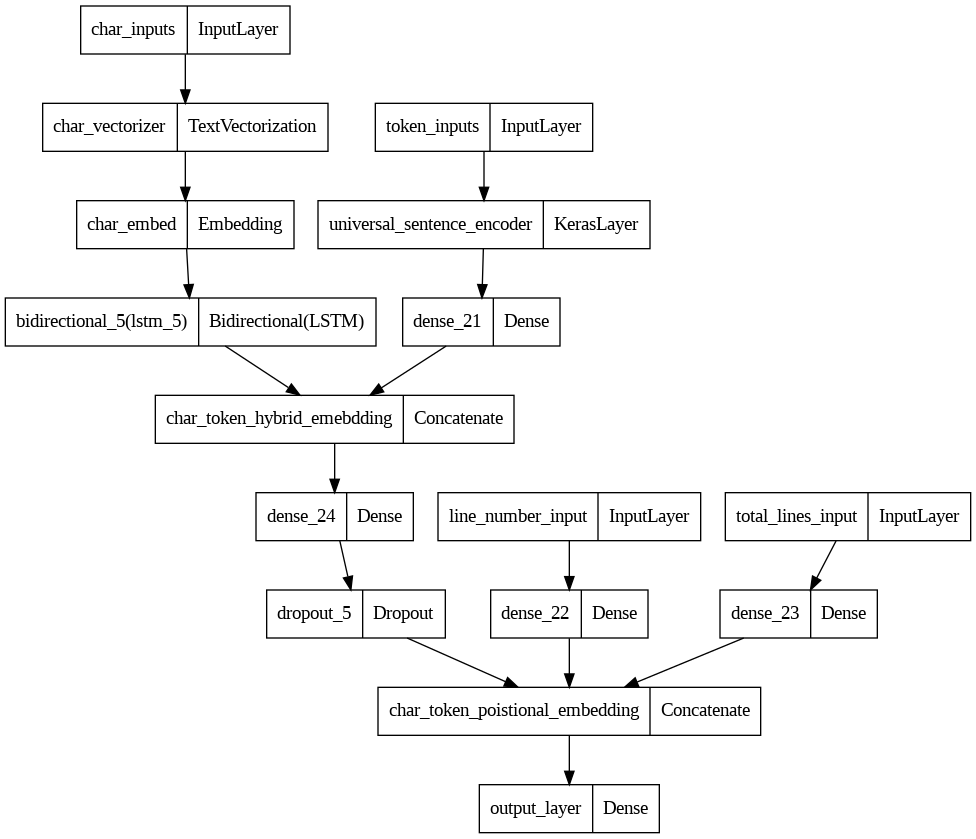

In [118]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_5)

In [121]:
# Compile token char and positional embedding
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

## Create Tribrid embeddings datasets using tf.data

In [125]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip(train_char_token_pos_data, train_char_token_pos_labels)
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validataion dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                             val_total_lines_one_hot,
                                                             val_sentences,
                                                             val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip(val_char_token_pos_data, val_char_token_pos_labels)
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [126]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [128]:
## Fit the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              epochs= 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 245s 415ms/step - loss: 1.0917 - accuracy: 0.7272 - val_loss: 0.9771 - val_accuracy: 0.8122
Epoch 2/3
562/562 [==============================] - 166s 296ms/step - loss: 0.9652 - accuracy: 0.8136 - val_loss: 0.9485 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 164s 293ms/step - loss: 0.9504 - accuracy: 0.8217 - val_loss: 0.9390 - val_accuracy: 0.8324


In [130]:
# make predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 60s 64ms/step


array([[0.49896002, 0.11422919, 0.01331404, 0.35672548, 0.01677131],
       [0.5142793 , 0.10295372, 0.04371633, 0.32818913, 0.01086151],
       [0.30096412, 0.0964389 , 0.10697258, 0.4350313 , 0.06059311],
       ...,
       [0.03539908, 0.11132859, 0.04349926, 0.03065819, 0.77911484],
       [0.03509357, 0.26961684, 0.08571953, 0.02618187, 0.58338815],
       [0.20818236, 0.57100135, 0.1216684 , 0.04206654, 0.05708129]],
      dtype=float32)

In [136]:
# Convert pred probs into labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [138]:
# Calculate the resulsts
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.46021448431087,
 'precision': 0.8337492563906082,
 'recall': 0.8346021448431087,
 'f1': 0.8335025865210635}

### Compare  model results

In [139]:
# Combine model results in a dataframe
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embeding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,73.970608,0.759340,0.739706,0.709995
model_1_custom_token_embedding,78.306633,0.779220,0.783066,0.780340
model_2_pretrained_token_embeding,71.531180,0.715634,0.715312,0.712468
model_3_custom_char_embedding,65.629551,0.655877,0.656296,0.646010
model_4_hybrid_char_token_embedding,73.507216,0.735254,0.735072,0.733250
model_5_pos_char_token_embedding,83.460214,0.833749,0.834602,0.833503


from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

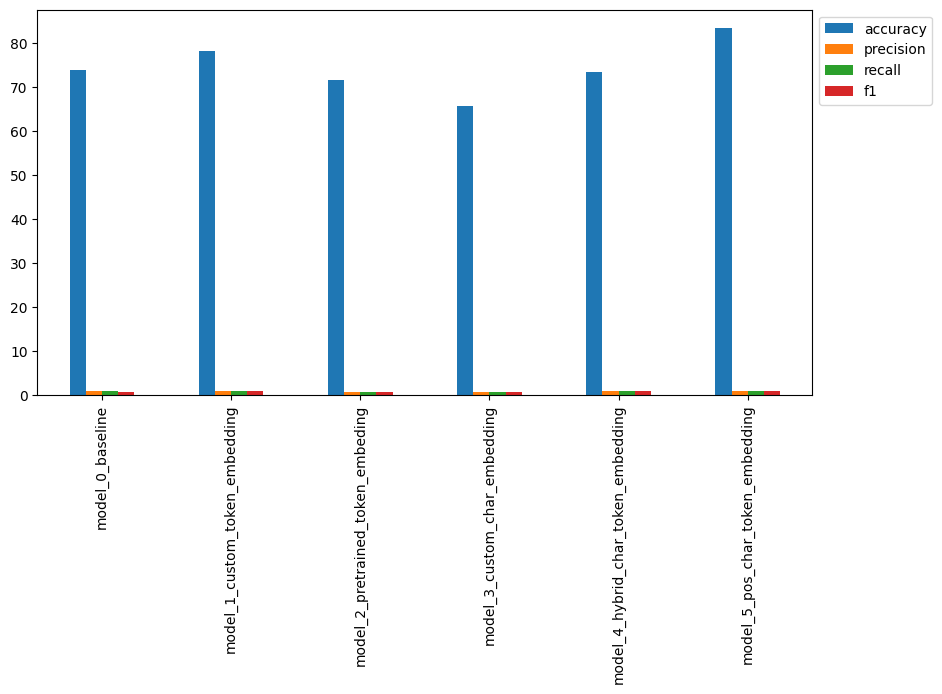

In [144]:
# prompt: Using dataframe all_model_results: bargraph

all_model_results.plot(kind='bar', figsize=(10, 5)).legend(bbox_to_anchor=(1.0, 1.0));


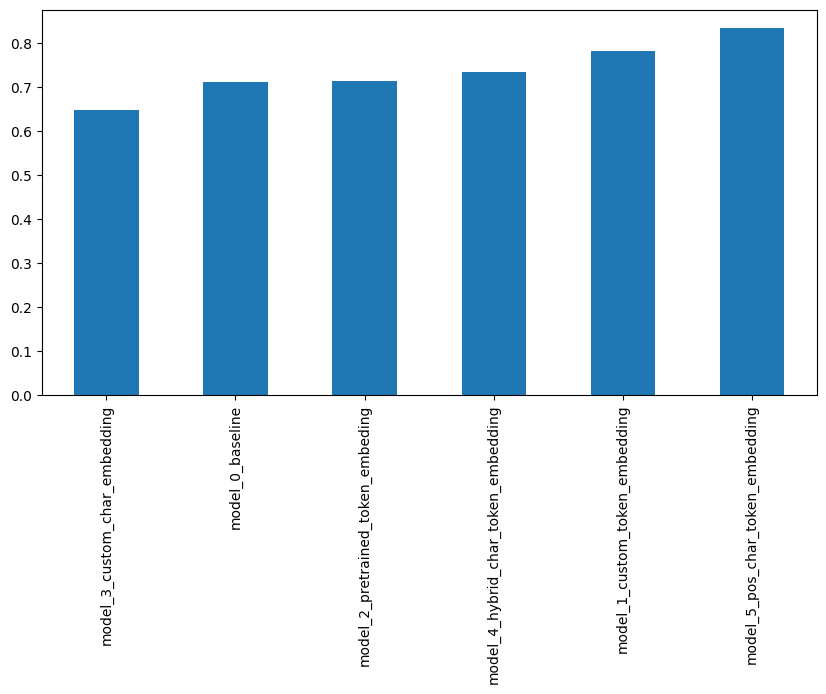

In [146]:
# Sort models by f1 score
all_model_results.sort_values("f1", ascending=True)['f1'].plot(kind='bar', figsize=(10,5));

### Save and Load the model

In [147]:
# Use the save model format
model_5.save("skimlit_tribrid_model")

In [149]:
# Load the model
loaded_model = tf.keras.models.load_model('/content/skimlit_tribrid_model')

In [156]:
 # Make prediction
 loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
 loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
 loaded_preds[:10]

945/945 [==============================] - 62s 65ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [157]:
# Calculate the results
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                        y_pred = loaded_preds)
loaded_model_results

{'accuracy': 83.46021448431087,
 'precision': 0.8337492563906082,
 'recall': 0.8346021448431087,
 'f1': 0.8335025865210635}

In [158]:
model_5_results

{'accuracy': 83.46021448431087,
 'precision': 0.8337492563906082,
 'recall': 0.8346021448431087,
 'f1': 0.8335025865210635}

In [166]:
assert model_5_results == loaded_model_results


In [161]:

# check loaded model summary
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_

Now the model has achived an optimal accuracy of 83%. We can advance further with the dataset

**Remember**

We only trained the model on 20k rct instead of 200k.
Also the model was only trained on 10% of the data (*recall* `int(0.1 * len(train_data etc ....))`)

# Follow the same exact steps for the 200K dataset
**N/B:**
It's going to take longer to train, I used CPU, Use a GPU